# Problem 1: Pairs Trading Strategy

In [1]:
from yahooquery import Screener, Ticker
import pandas as pd
import statsmodels.api as sm
import numpy as np
import math
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

In [2]:
#pip install yahooquery

# Question 1

Our group want to rationalize our choice of instruments from two perspectives: **economical reason and statistical test**. <br>
1. We chose 9 securities in the beverage industry of S&P 500. Because we believed that companies in the same industry are **exposed to similar risk**. For instance, all beverage companies face supply chain challange, similar policy and customer attitudes, etc. <br>
2. Secondly, by **Engle-Granger cointegration test**, we put these 9 securities into the function of find_cointegrated_pairs to calculate the cointergrate scores and corresponding p values of various pairs in last 2000 days, which can help us find the all cointegrated pairs. <br>
3. Finally, we aimed to find the optimal pair which **passes cointegrated test** and also has **similar market capital size and financial ratios**.



**9 Beverage Securities** are as follows:<br>

PEP — Pepsico, Inc., <br>
KO — Coca-Cola Company, <br>
MNST — Monster Beverage Corporation, <br>
KDP — Keurig Dr Pepper Inc., <br>
CELH — Celsius Holdings, Inc., <br>
FIZZ — National Beverage Corp., <br>
SBUX — Starbucks Corporation, <br>
MDLZ — Mondelez International, Inc., <br>
STZ — Constellation Brands, Inc.

In [3]:
def get_data(ticker_names, days=1000):
    """
    ticker_names: list
    # output
    table: pd.DataFrame
    """
    yh_conn = Ticker(ticker_names)
    res = yh_conn.history(period=f"{days}D", interval='1d')
    table = None
    for crypto in res.index.get_level_values(0).unique().tolist():
        temp = res.loc[crypto, ]
        temp.columns = [crypto.split("-")[0] + "-" + x for x in temp.columns.tolist()]
        if table is None:
            table = temp
        else:
            table = pd.merge(table, temp, how='outer', left_index=True, right_index=True)
    table.reset_index(inplace=True)
    table['date'] = pd.to_datetime(table['date'])
    return table

In [4]:
def find_cointegrated_pairs(data):
    """
    data: pd.DataFrame
    # output
    pairs_result: pd.DataFrame
    """
    
    # Use the Engle-Granger test to test whether residual is I(0).
    # H_0 is residual is I(1), H_1 is residual is I(0).
    
    
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    scores = []
    pvalues = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
                scores.append(score_matrix[i,j])
                pvalues.append(pvalue_matrix[i,j])
                
    pairs_result = pd.DataFrame({'pairs': pairs, 'scores': scores, 'pvalues': pvalues}, 
                                columns=['pairs', 'scores', 'pvalues'])
    pairs_result.sort_values(by=['pvalues'])
    return pairs_result

In [5]:
def stationarity_test(data, cutoff=0.01):
    """
    data: pd.DataFrame
    cutoff: 0.01
    # output
    stationarity_result: string
    """
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(data)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + data.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + data.name +' is likely non-stationary.')

In [6]:
# find cointergrated pairs from 11 securities in food and beverage industry
pair_tickers = ['PEP', 'KO', 'MNST', 'KDP', 'CELH', 'FIZZ', 'SBUX', 'MDLZ', 'STZ']

df = get_data(pair_tickers, 2000)
df.tail()

,date,PEP-open,PEP-low,PEP-volume,PEP-high,PEP-close,PEP-adjclose,PEP-dividends,PEP-splits,KO-open,...,MDLZ-dividends,MDLZ-splits,STZ-open,STZ-low,STZ-volume,STZ-high,STZ-close,STZ-adjclose,STZ-dividends,STZ-splits
1995,2022-12-09,184.210007,183.050003,3116100,184.210007,183.100006,183.100006,0.0,0.0,63.610001,...,0.0,0.0,245.300003,241.889999,740600,246.589996,242.039993,242.039993,0.0,0.0
1996,2022-12-12,184.179993,182.360001,4691400,184.179993,183.970001,183.970001,0.0,0.0,63.299999,...,0.0,0.0,242.619995,241.149994,603500,245.570007,245.490005,245.490005,0.0,0.0
1997,2022-12-13,186.479996,182.940002,5634900,186.839996,183.869995,183.869995,0.0,0.0,64.589996,...,0.0,0.0,248.440002,240.220001,1889800,248.440002,240.860001,240.860001,0.0,0.0
1998,2022-12-14,184.070007,182.130005,5392500,185.880005,183.360001,183.360001,0.0,0.0,64.190002,...,0.0,0.0,241.449997,238.059998,1238300,242.729996,239.550003,239.550003,0.0,0.0
1999,2022-12-15,181.979996,178.389999,6127800,182.710007,180.250000,180.250000,0.0,0.0,63.590000,...,0.0,0.0,237.770004,233.429993,1404000,239.539993,235.399994,235.399994,0.0,0.0


In [7]:
findpair_data = df[[x + "-adjclose" for x in pair_tickers]]
findpair_data.head()

,PEP-adjclose,KO-adjclose,MNST-adjclose,KDP-adjclose,CELH-adjclose,FIZZ-adjclose,SBUX-adjclose,MDLZ-adjclose,STZ-adjclose
0,77.362251,33.655193,39.236668,10.087617,0.46,9.272329,35.575485,32.107143,97.409782
1,76.838455,33.283913,39.013332,10.040037,0.52,9.092046,34.411057,31.791111,97.138329
2,76.520988,32.982250,37.320000,9.955747,0.52,9.128922,34.600822,31.492153,96.803474
3,76.465446,32.974510,37.703335,10.031878,0.50,9.341984,34.876839,31.287174,96.197151
4,76.719414,32.920372,39.246666,10.170549,0.45,9.231356,34.682758,31.218828,98.124733


In [8]:
pairs_result = find_cointegrated_pairs(findpair_data)
pairs_result

,pairs,scores,pvalues
0,"(PEP-adjclose, KO-adjclose)",-3.777551,0.014519
1,"(MNST-adjclose, CELH-adjclose)",-3.712288,0.017669
2,"(FIZZ-adjclose, STZ-adjclose)",-3.357595,0.047283


In [9]:
# Stationarity Test
print(stationarity_test(np.log1p(findpair_data['KO-adjclose'].pct_change()[1:]), cutoff=0.01))
print(stationarity_test(np.log1p(findpair_data['PEP-adjclose'].pct_change()[1:]), cutoff=0.01))

p-value = 4.2479877702748937e-26 The series KO-adjclose is likely stationary.
None
p-value = 6.816167181064719e-25 The series PEP-adjclose is likely stationary.
None


We found three pairs whose cointegrated scores passed p values test, ie., p values are lower than 0.05. We also test the stationarity of these two securites return and we found that both of them are stationary as they have p values less than thershold (0.1). <br>
As a result, we chose **PEP (Pepsico) and KO (Coca-Cola)** as the optimal pair to trade below since their p value is minimum, which means they are highly cointergrated. At the same time, they have very similar market capitalization.

In [10]:
ticker_list = ['KO','PEP']

<AxesSubplot:>

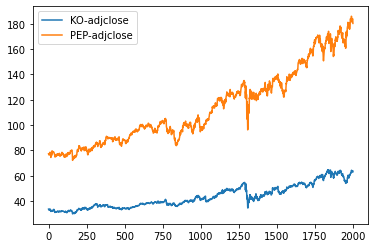

In [11]:
findpair_data[[x + "-adjclose" for x in ticker_list]].plot()

# Question 2

To construct Z-scores, we firstly need to calculate the residual R(tau). By cointegration approach, **R(tau) = A(tau)-beta*B(tau)-alpha**. In Q1, we have proved the cointegrated property of PEP (Pepsico) and KO (Coca-Cola). A(t) is KO and B(t) is PEP. Then we use **ordinary least squares (OLS)** to get significant alpha and beta. The Z-scores calculation details are in the function of **generate_single_signal()**. Z-scores results are in **"signals_df"**. The visualization and analysis of Z-scores are in the following.

In [12]:
def generate_single_signal(x, D_up: float=1, D_down: float=1):
    """
    x: pd.DataFrame
    D_up: float, start point = 1
    D_down: float, start point = 1
    # output: 
    1 for long, -1 for short, 0 for no trading
    date
    """
    A_colname = ticker_list[0] + "-adjclose"
    B_colname = ticker_list[1] + "-adjclose"
    A, B = np.log(x[A_colname].iloc[:-1]), np.log(x[B_colname].iloc[:-1])
    B_constant = sm.add_constant(B)
    model = sm.OLS(A, B_constant)
    results = model.fit()
    alpha, beta = results.params[0], results.params[1]
    
    # r_sigma is S(tau) - the volatility of the residual
    r_sigma = np.sqrt(np.sum(results.resid**2)/results.df_resid)
    
    # results.predict(B) = alpha + beta*B 
    residual_cal = A - results.predict(B_constant)
    
    #Question 2: Residual and Z-scores
    A_t = np.log(x[A_colname]).values[-1]
    B_t = np.log(x[B_colname]).values[-1]
    R_t = A_t - alpha - beta * B_t
    Z_t = R_t / r_sigma
    
    #Question 3: Optimal entry adna exit point
    return [x['date'].iloc[-1], alpha, beta, Z_t, -1 if Z_t > D_up else (1 if Z_t < - D_down else 0)]

In [13]:
def produce_signals(x, L=61, D_up=1.0, D_down=1.0):
    """
    x: pd.DataFrame
    L: int
    D_up: float, start point = 1
    D_down: float, start point = 1
    # output
    res: pd.DataFrame
    """
    res = []
    for ix in range(L, x.shape[0]):
        res.append(generate_single_signal(x.iloc[ix - L:ix + 1, :], D_up, D_down))
    res_df = pd.DataFrame(res, columns=['Date','alpha','Beta','Z_t','Signal'])
    return res_df

In [14]:
# We set 1000 trading days
data = get_data(ticker_list, 1000)
data.head(11)

,date,KO-open,KO-volume,KO-low,KO-high,KO-close,KO-adjclose,KO-dividends,PEP-open,PEP-volume,PEP-low,PEP-high,PEP-close,PEP-adjclose,PEP-dividends
0,2018-12-28,47.889999,13218200,47.029999,48.009998,47.200001,41.652256,0.0,110.089996,5410300,109.220001,111.099998,110.360001,98.551903,0.0
1,2018-12-31,47.490002,10576300,46.959999,47.540001,47.349998,41.784626,0.0,110.580002,5019100,109.320000,111.089996,110.480003,98.659065,0.0
2,2019-01-02,46.939999,11603700,46.560001,47.220001,46.930000,41.413990,0.0,109.150002,4835400,108.230003,110.019997,109.279999,97.587456,0.0
3,2019-01-03,46.820000,14714400,46.529999,47.369999,46.639999,41.158073,0.0,108.910004,5975900,108.050003,110.150002,108.260002,96.676582,0.0
4,2019-01-04,46.750000,13013700,46.639999,47.570000,47.570000,41.978767,0.0,109.540001,6293900,108.239998,110.599998,110.480003,98.659065,0.0
5,2019-01-07,47.570000,13135500,46.900002,47.750000,46.950001,41.431633,0.0,110.010002,5220300,108.650002,110.379997,109.529999,97.810692,0.0
6,2019-01-08,47.250000,15420700,47.040001,47.570000,47.480000,41.899349,0.0,110.139999,6407700,109.419998,110.800003,110.580002,98.748367,0.0
7,2019-01-09,47.080002,18032500,46.430000,47.279999,46.570000,41.096306,0.0,110.330002,8521300,107.489998,110.870003,107.489998,95.988983,0.0
8,2019-01-10,46.660000,15976600,46.340000,47.090000,47.070000,41.537540,0.0,107.410004,7905000,107.360001,108.339996,108.150002,96.578362,0.0
9,2019-01-11,47.290001,11088600,46.970001,47.360001,47.340000,41.775799,0.0,107.860001,5939000,107.639999,108.500000,108.160004,96.587288,0.0


In [15]:
# The "Signal" for the "Date" is determined by the the Z-score and D_up&D-down result of previous L days.
signals_df = produce_signals(data)
signals_df

,Date,alpha,Beta,Z_t,Signal
0,2019-03-28,5.368616,-0.356398,1.126967,-1
1,2019-03-29,5.252169,-0.331091,1.317048,-1
2,2019-04-01,5.108084,-0.299812,1.032789,-1
3,2019-04-02,5.032770,-0.283394,0.817351,0
4,2019-04-03,5.014548,-0.279306,0.469762,0
...,...,...,...,...,...
934,2022-12-09,-0.683097,0.921964,0.856229,0
935,2022-12-12,-0.836860,0.951667,1.142935,-1
936,2022-12-13,-1.069251,0.996602,1.135446,-1
937,2022-12-14,-1.274786,1.036330,1.210540,-1


In [16]:
signals_df['Z_t'].describe()

count    939.000000
mean       0.155412
std        1.602287
min       -6.389332
25%       -0.952762
50%        0.413091
75%        1.176656
max        7.622879
Name: Z_t, dtype: float64

<AxesSubplot:>

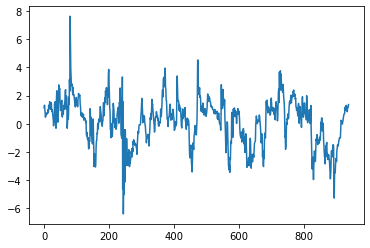

In [17]:
signals_df['Z_t'].plot()

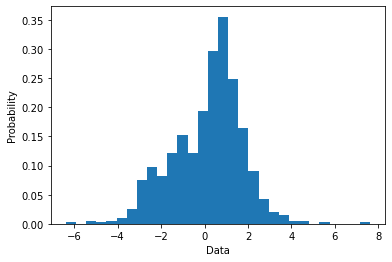

In [18]:
%matplotlib inline

plt.hist(signals_df['Z_t'], density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

# Question 3

We initialize **L=61, W=7, D_up=1.0, and D_down=1.0**. We have entry threshold D_up and exit threshold D_down. All calculations are operated by functions of **generate_single_signal() and produce_signals()** in Q2. In each interval [t-L, t-1], we compare the values of Z-score and D_up&D-down to determine an optimal trading rule. Then, the rule is applied to the interval [t+1,t+W]. If Z_t > D_up, we will long beta*B(t) and short A(t). If Z_t < D_down, we will long A(t) and short beta*B(t). On the day of t+W, the operation is opposite.

In [19]:
signals_df

,Date,alpha,Beta,Z_t,Signal
0,2019-03-28,5.368616,-0.356398,1.126967,-1
1,2019-03-29,5.252169,-0.331091,1.317048,-1
2,2019-04-01,5.108084,-0.299812,1.032789,-1
3,2019-04-02,5.032770,-0.283394,0.817351,0
4,2019-04-03,5.014548,-0.279306,0.469762,0
...,...,...,...,...,...
934,2022-12-09,-0.683097,0.921964,0.856229,0
935,2022-12-12,-0.836860,0.951667,1.142935,-1
936,2022-12-13,-1.069251,0.996602,1.135446,-1
937,2022-12-14,-1.274786,1.036330,1.210540,-1


In [20]:
signals_df.Signal.value_counts()

 0    430
-1    290
 1    219
Name: Signal, dtype: int64

# Question 4

The function of **back_test()** calculates **cumulative pnl, sharpe ratio and drawdowns** of our strategy.

In [21]:
# Question 4: drawdowns
def calcdrawdown(back_test: pd.DataFrame):
    """
    back_test: pd.DataFrame
    # output
    MaxDD: float
    """
    back_test = back_test.copy()
    back_test['pnl_MAX'] = back_test['pnl'].cummax()
    return -max((back_test['pnl_MAX'] - back_test['pnl']) / back_test['pnl_MAX'])

In [22]:
def back_test(x, L = 10, W = 2, D_up=100000.0, D_down=90.0):
    """
    x: pd.DataFrame
    L: int, training window
    W: int, testing/trading window
    D_up: float, start point = 1
    D_down: float, start point = 1
    # output
    back_test: pd.DataFrame
    drawdown: float
    sharpe: float
    """
    cols = [comp + "-adjclose" for comp in ticker_list]
    signal_raw = produce_signals(x, L, D_up, D_down)
    signal = signal_raw.loc[:,['Date','Signal','Beta']]
    price = x[cols].iloc[L:, :].copy().reset_index()
    back_test = pd.concat([price, signal], axis=1, ignore_index=False)
    back_test.drop(columns=['index'], inplace=True)
    back_test[cols[0] + '-shifted'] = back_test[cols[0]].shift(-W)
    back_test[cols[1] + '-shifted'] = back_test[cols[1]].shift(-W)
    back_test['Return'] = - back_test['Signal'] * ((np.log(back_test[cols[0] + '-shifted']) - np.log(back_test[cols[0]])) - 
                                                   back_test['Beta'] * (np.log(back_test[cols[1] + '-shifted']) - np.log(back_test[cols[1]])))
    back_test = back_test.iloc[0::W, :]
    
    # Question 4: cumulative pnl
    back_test['pnl'] = (1 + back_test['Return']).cumprod()
    back_test.dropna(inplace=True)

    ann_sigma = np.sqrt(252 / W) * back_test['Return'].std()
    ann_ret = (back_test['pnl'].iloc[-1] - 1) * (252 / (back_test.shape[0] * W))

    drawdown = calcdrawdown(back_test)
    # Question 4: sharpe ratio
    sharpe = ann_ret / ann_sigma
    
    return back_test, drawdown, sharpe

In [23]:
q4_cumu_pnl,dd,sharpe = back_test(data,61,7,0.95,1.35)
q4_cumu_pnl

,KO-adjclose,PEP-adjclose,Date,Signal,Beta,KO-adjclose-shifted,PEP-adjclose-shifted,Return,pnl
0,41.463970,109.685860,2019-03-28,-1,-0.356398,41.437260,109.829903,-0.000177,0.999823
7,41.437260,109.829903,2019-04-08,0,-0.249986,42.087090,114.340118,0.000000,0.999823
14,42.087090,114.340118,2019-04-17,-1,-0.211640,43.101875,114.052063,0.023292,1.023111
21,43.101875,114.052063,2019-04-29,-1,0.041048,42.594475,113.448875,-0.011624,1.011218
28,42.594475,113.448875,2019-05-08,0,0.419463,43.796204,117.490974,0.000000,1.011218
...,...,...,...,...,...,...,...,...,...
903,58.971760,177.959930,2022-10-26,1,1.439349,58.842674,177.671722,-0.000142,1.630911
910,58.842674,177.671722,2022-11-04,0,1.031324,60.203030,176.091583,0.000000,1.630911
917,60.203030,176.091583,2022-11-15,0,0.766937,62.248520,182.968674,0.000000,1.630911
924,62.248520,182.968674,2022-11-25,0,0.661175,63.439999,181.630005,0.000000,1.630911


In [24]:
print('When L = 10, W = 2, for PEP and KO, our strategy sharpe ratio is {} and drawdown is {}'.format(sharpe,dd))

When L = 10, W = 2, for PEP and KO, our strategy sharpe ratio is 1.7273609257974805 and drawdown is -0.13073633909379198


# Question 5

To explore the sensitivity, we tuned 4 parameters here, including training window (L), testing window (W), optimal exit (D_up) and optimal entry (D_down). 

## Sensitivity of Sharpe Ratio with Respect to L

In [25]:
def tune_hyper_L(x: pd.DataFrame):
    """
    x: pd.DataFrame
    # output
    tunning_result: pd.DataFrame
    """
    L_list = [20,25,30,35,40,45,50,55,60,61,62,63,64,65,66,67,68,69,70,75,80,85,90,95,100]
    W = 7
    D_up = 0.95
    D_down = 1.35

    return pd.DataFrame([[L, 
                          back_test(x, L, W, D_up, D_down)[0]['pnl'].iloc[-1], 
                          back_test(x, L, W, D_up, D_down)[1],
                          back_test(x, L, W, D_up, D_down)[2]]
                         for L in L_list], 
                 columns=['L', 'pnl', 'drawdown', 'sharpe'])

In [26]:
df_L = tune_hyper_L(data)
df_L_sort = df_L.sort_values(by=['sharpe'], ascending=False)

In [27]:
df_L_sort

,L,pnl,drawdown,sharpe
9,61,1.632902,-0.130736,1.727361
16,68,1.573332,-0.093845,1.625848
19,75,1.409842,-0.101768,1.171783
11,63,1.430376,-0.143282,1.058073
18,70,1.394007,-0.144072,1.017767
17,69,1.361068,-0.101756,0.972224
10,62,1.335926,-0.150893,0.865040
8,60,1.345671,-0.185586,0.779491
15,67,1.344184,-0.183800,0.769278
22,90,1.181191,-0.094236,0.540233


Text(0, 0.5, 'sharpe ratio')

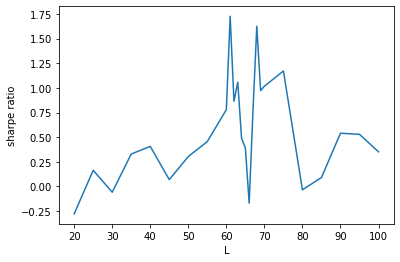

In [28]:
plt.plot(df_L.L,df_L.sharpe)
plt.xlabel('L')
plt.ylabel('sharpe ratio')

We fixed W = 7, D_up = 0.95 and D_down = 1.35, and set L's range as [20,100]. We got the optimal sharpe ratio at 1.727361 when L = 61. We found that when L changes between 20 to 100, the corresponding sharpe ratio changes between -0.25 to 1.75.

## Sensitivity of Sharpe Ratio with Respect to W

In [29]:
def tune_hyper_W(x: pd.DataFrame):
    """
    x: pd.DataFrame
    # output
    tunning_result: pd.DataFrame
    """
    L = 61
    W_list = [1,2,3,4,5,6,7,8,9,10,11,15,17]
    D_up = 0.95
    D_down = 1.35

    return pd.DataFrame([[W, 
                          back_test(x, L, W, D_up, D_down)[0]['pnl'].iloc[-1], 
                          back_test(x, L, W, D_up, D_down)[1],
                          back_test(x, L, W, D_up, D_down)[2]]
                         for W in W_list], 
                 columns=['W', 'pnl', 'drawdown', 'sharpe'])

In [30]:
df_W = tune_hyper_W(data)
df_W_sort = df_W.sort_values(by=['sharpe'], ascending=False)

In [31]:
df_W_sort

,W,pnl,drawdown,sharpe
6,7,1.632902,-0.130736,1.727361
10,11,1.717032,-0.118600,1.538022
7,8,1.409373,-0.071116,1.125050
12,17,1.224344,-0.212447,0.533910
3,4,1.210032,-0.181344,0.492615
9,10,1.146285,-0.163459,0.440176
8,9,1.173617,-0.151694,0.437408
5,6,1.116391,-0.139018,0.301242
1,2,1.085076,-0.208919,0.179774
4,5,0.998813,-0.270615,-0.002988


Text(0, 0.5, 'sharpe ratio')

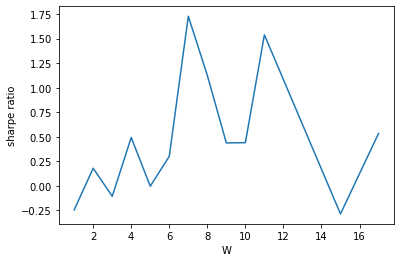

In [32]:
plt.plot(df_W.W,df_W.sharpe)
plt.xlabel('W')
plt.ylabel('sharpe ratio')

We fixed L = 61, D_up = 0.95 and D_down = 1.35, and set W's range as [1,17]. We got the optimal sharpe ratio at 1.727361 when W = 7. We found that when W changes between 1 to 17, the corresponding sharpe ratio changes between -0.25 to 1.75. Comparing with the result above, sharpe ratio is more sensitive to W than L.

## Sensitivity of Sharpe Ratio with Respect to D_up

In [33]:
def tune_hyper_up(x: pd.DataFrame):
    """
    x: pd.DataFrame
    # output
    tunning_result: pd.DataFrame
    """
    L = 61
    W = 7
    D_up_list = [0.4,0.5,0.6,0.7,0.8,0.9,0.92,0.93,0.95,0.97,1.0,1.2,1.4,1.5,1.7,1.9]
    D_down = 1.35

    return pd.DataFrame([[D_up, 
                          back_test(x, L, W, D_up, D_down)[0]['pnl'].iloc[-1], 
                          back_test(x, L, W, D_up, D_down)[1],
                          back_test(x, L, W, D_up, D_down)[2]]
                         for D_up in D_up_list], 
                 columns=['D_up', 'pnl', 'drawdown', 'sharpe'])

In [34]:
df_up = tune_hyper_up(data)
df_up_sort = df_up.sort_values(by=['sharpe'], ascending=False)

In [35]:
df_up_sort

,D_up,pnl,drawdown,sharpe
2,0.60,1.738184,-0.125777,1.913736
1,0.50,1.735486,-0.125777,1.905821
5,0.90,1.651804,-0.130736,1.776584
8,0.95,1.632902,-0.130736,1.727361
9,0.97,1.632902,-0.130736,1.727361
6,0.92,1.629874,-0.130736,1.718674
7,0.93,1.629874,-0.130736,1.718674
3,0.70,1.648194,-0.125777,1.697603
10,1.00,1.614953,-0.130736,1.679311
11,1.20,1.577650,-0.125777,1.596814


Text(0, 0.5, 'sharpe ratio')

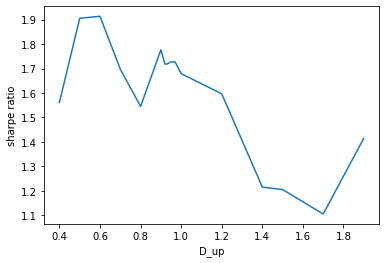

In [36]:
plt.plot(df_up.D_up,df_up.sharpe)
plt.xlabel('D_up')
plt.ylabel('sharpe ratio')

We fixed L = 61, W = 7 and D_down = 1.35, and set D_up's range as [0.40,1.90]. We got the optimal sharpe ratio at 1.913736 when D_up = 0.60. We found that when D_up changes between 0.40 to 1.90, the corresponding sharpe ratio changes between 1.10 to 1.90.

## Sensitivity of Sharpe Ratio with Respect to D_down

In [37]:
def tune_hyper_down(x: pd.DataFrame):
    """
    x: pd.DataFrame
    # output
    tunning_result: pd.DataFrame
    """
    L = 61
    W = 7
    D_up = 0.60
    D_down_list = [0.6,0.7,0.8,0.9,0.95,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]

    return pd.DataFrame([[D_down, 
                          back_test(x, L, W, D_up, D_down)[0]['pnl'].iloc[-1], 
                          back_test(x, L, W, D_up, D_down)[1],
                          back_test(x, L, W, D_up, D_down)[2]]
                         for D_down in D_down_list], 
                 columns=['D_down', 'pnl', 'drawdown', 'sharpe'])

In [38]:
df_down = tune_hyper_down(data)
df_down_sort = df_down.sort_values(by=['sharpe'], ascending=False)

In [39]:
df_down_sort

,D_down,pnl,drawdown,sharpe
10,1.50,1.882577,-0.056580,2.488259
11,1.60,1.792563,-0.060162,2.263860
12,1.70,1.758558,-0.060162,2.173496
13,1.80,1.642328,-0.060162,1.981287
14,1.90,1.642328,-0.060162,1.981287
9,1.40,1.748912,-0.125777,1.943765
15,2.00,1.613532,-0.056580,1.904132
8,1.30,1.729031,-0.130381,1.888278
7,1.20,1.707975,-0.130381,1.828925
6,1.10,1.655539,-0.130381,1.668791


Text(0, 0.5, 'sharpe ratio')

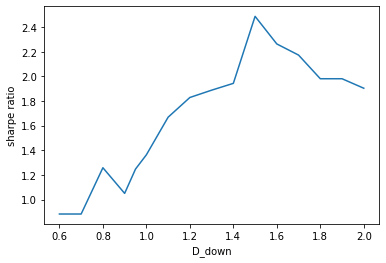

In [40]:
plt.plot(df_down.D_down,df_down.sharpe)
plt.xlabel('D_down')
plt.ylabel('sharpe ratio')

We fixed L = 61, W = 7 and D_up = 0.60, and set D_down's range as [0.60,2.00]. We got the optimal sharpe ratio at 2.488259 when D_down = 1.50. We found that when D_down changes between 0.60 to 2.00, the corresponding sharpe ratio changes between 1.00 to 2.40. Comparing with the result above, sharpe ratio is more sensitive to D_down than D_up. Therefore, we picked the L = 61, W = 7, D_up = 0.60 and D_down = 1.50 as our optimal parameters as they generate the best sharpe ratio. 

## Optimal Hyperparameters: L = 61, W =7, D_up=0.60, D_down=1.50

In [41]:
optimal_df, dd, sharpe = back_test(data, L = 61, W =7, D_up=0.60, D_down=1.50)
optimal_df.head()

,KO-adjclose,PEP-adjclose,Date,Signal,Beta,KO-adjclose-shifted,PEP-adjclose-shifted,Return,pnl
0,41.463970,109.685860,2019-03-28,-1,-0.356398,41.437260,109.829903,-0.000177,0.999823
7,41.437260,109.829903,2019-04-08,-1,-0.249986,42.087090,114.340118,0.025621,1.025440
14,42.087090,114.340118,2019-04-17,-1,-0.211640,43.101875,114.052063,0.023292,1.049324
21,43.101875,114.052063,2019-04-29,-1,0.041048,42.594475,113.448875,-0.011624,1.037126
28,42.594475,113.448875,2019-05-08,0,0.419463,43.796204,117.490974,0.000000,1.037126


<AxesSubplot:>

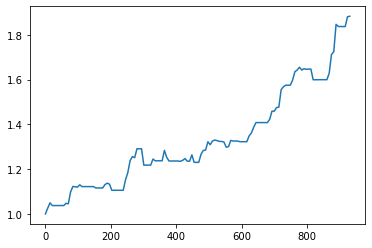

In [42]:
optimal_df['pnl'].plot()

<AxesSubplot:>

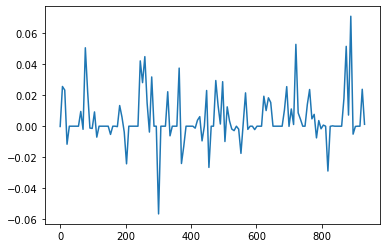

In [43]:
optimal_df['Return'].plot()

In [44]:
(optimal_df['Return'] > 0).value_counts()

False    83
True     51
Name: Return, dtype: int64

In last 1000 days, amongs the days we trades, we made money in 51 days and lost money in 83 days. 

In [45]:
#cumul pnl
optimal_df.pnl.iloc[-1]

1.8825770562726845

In [46]:
# Max Drawdown
dd

-0.056579566422091394

In [47]:
# Sharpe Ratio
sharpe

2.4882592039044353

With our pairs trading strategy, cumulative pnl in 1000 trading days is about 88.26%, maximum drawdown is about -5.66%, sharpe ratio is 2.49.